# 01. OpenBB to HMM Regimes (End-to-End)

This notebook demonstrates a full workflow:

1. Download daily prices from OpenBB.
2. Fit a 3-state Gaussian HMM.
3. Label latent states by realized volatility (`calm`, `neutral`, `stress`).
4. Save core artifacts for downstream analysis.
5. Visualize inferred regimes on the price chart.


## Prerequisites

- You should have installed this package in editable mode.
- OpenBB should be available in your active environment.
- This notebook uses `SPY` and `yfinance` by default; change the config cell if needed.


In [1]:
from pathlib import Path

import pandas as pd
from IPython.display import display

from hmm_regime.data import download_openbb_prices
from hmm_regime.model import HMMConfig
from hmm_regime.pipeline import run_regime_pipeline
from hmm_regime.plotting import plot_price_with_regimes


In [2]:
# --- Configuration ---
SYMBOL = "SPY"
START_DATE = "2015-01-01"
END_DATE = "2025-12-31"
PROVIDER = "yfinance"
CLOSE_COL = "close"

OUTPUT_DIR = Path("../outputs/notebook_openbb_spy")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

HMM_CFG = HMMConfig(
    n_states=3,
    covariance_type="full",
    n_iter=300,
    tol=1e-4,
    random_state=42,
)


In [3]:
# --- Step 1: Download prices from OpenBB ---
prices = download_openbb_prices(
    symbol=SYMBOL,
    start_date=START_DATE,
    end_date=END_DATE,
    provider=PROVIDER,
    close_col=CLOSE_COL,
)

print(f"rows={len(prices)}")
print(f"start={prices.index.min()}  end={prices.index.max()}")
display(prices.head())


rows=2766
start=2015-01-02 00:00:00  end=2025-12-31 00:00:00


,close
datetime,
2015-01-02,205.429993
2015-01-05,201.720001
2015-01-06,199.820007
2015-01-07,202.309998
2015-01-08,205.899994


## Feature/Model pipeline

`run_regime_pipeline(...)` internally:

- builds a deterministic feature matrix from close prices,
- fits the Gaussian HMM,
- decodes latent states,
- computes transition matrix + duration stats + return summary.


In [4]:
# --- Step 2: Run the regime pipeline ---
result = run_regime_pipeline(
    prices,
    close_col=CLOSE_COL,
    hmm_config=HMM_CFG,
)

print("state label map:")
for state, label in sorted(result.state_label_map.items()):
    print(f"  state {state}: {label}")


Model is not converging.  Current: 34469.45577160705 is not greater than 34469.78516961797. Delta is -0.3293980109228869


state label map:
  state 0: neutral
  state 1: stress
  state 2: calm


In [5]:
# --- Step 3: Save artifacts ---
states_df = pd.concat(
    [
        result.close.reindex(result.states.index).rename("close"),
        result.log_returns.rename("log_ret_1"),
        result.states,
        result.regime_labels,
        result.state_probabilities,
    ],
    axis=1,
)

states_path = OUTPUT_DIR / "states.csv"
transition_path = OUTPUT_DIR / "transition_matrix.csv"
duration_path = OUTPUT_DIR / "duration_stats.csv"
summary_path = OUTPUT_DIR / "return_summary.csv"

states_df.to_csv(states_path, index=True)
result.transition_matrix.to_csv(transition_path, index=True)
result.duration_stats.to_csv(duration_path, index=True)
result.return_summary.to_csv(summary_path, index=True)

print("Saved files:")
for p in [states_path, transition_path, duration_path, summary_path]:
    print("-", p.resolve())


Saved files:
- /Users/mengren/Documents/new_projects/hmm-market-regime-detection/outputs/notebook_openbb_spy/states.csv
- /Users/mengren/Documents/new_projects/hmm-market-regime-detection/outputs/notebook_openbb_spy/transition_matrix.csv
- /Users/mengren/Documents/new_projects/hmm-market-regime-detection/outputs/notebook_openbb_spy/duration_stats.csv
- /Users/mengren/Documents/new_projects/hmm-market-regime-detection/outputs/notebook_openbb_spy/return_summary.csv


In [6]:
# --- Step 4: Inspect tabular diagnostics ---
display(result.transition_matrix)
display(result.duration_stats)
display(result.return_summary)


to_state,0,1,2
from_state,,,
0,0.980249,0.005198,0.014553
1,0.107143,0.892857,0.000000
2,0.004470,0.004470,0.991060


,episodes,total_bars,mean_duration,median_duration,max_duration
state,,,,,
0,19,962,50.631579,49.0,105
1,12,112,9.333333,2.5,62
2,15,1567,104.466667,63.0,383


,n_obs,mean_log_return,std_log_return,ann_return,ann_vol,sharpe,hit_rate
state,,,,,,,
0,962,0.000681,0.011840,0.171526,0.187947,0.912629,0.534304
1,112,-0.004439,0.035140,-1.118660,0.557825,-2.005397,0.455357
2,1567,0.000659,0.006667,0.165990,0.105833,1.568415,0.563497


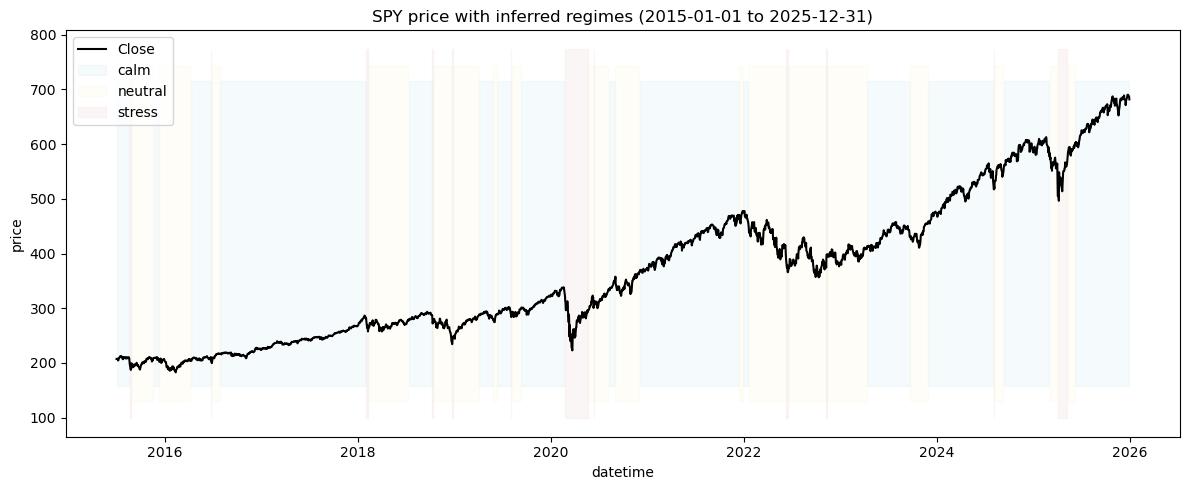

In [7]:
# --- Step 5: Regime visualization ---
fig, ax = plot_price_with_regimes(
    close=result.close.reindex(result.regime_labels.index),
    regimes=result.regime_labels,
    title=f"{SYMBOL} price with inferred regimes ({START_DATE} to {END_DATE})",
)


## Interpretation Checklist

- **Return summary**: does `stress` show lower return / higher vol than `calm`?
- **Transition matrix**: are diagonal probabilities high enough to imply persistence?
- **Duration stats**: do regime episode lengths match market intuition?

If labels look unstable, tune:
- `n_states`
- feature windows (especially volatility/trend windows)
- date frequency (daily vs weekly)
